<link rel="stylesheet" type="text/css" href="final.css">

<h1>Analysis of NFL Statistics and Season Outcomes</h1>
<p>Collaborators: Angelo Navaleza, Simon Nguyen, Kevin Zhou</p>

<h2>Introduction</h2>

Out of the four major sports leagues here in the United States, American Football and the National Football League (NFL) consistently ranks as one of the most-watched programs year after year. The purpose of this project is to walk you through the data science pipeline, while analyzing this trove of team statistics and data from 2013 to 2023. This dataset encapsulates NFL performance year by year for each of the 32 teams within the league, in order to get a comprehensive view of each season and its outcome. The analysis of NFL statistics has major significance, serving as a window into the intracacies of a sport that captivate millions of viewers every year. While analyzing these statistics are significant to sports fans around the world, but it can also offer insights into societal trends, economic impacts, and cultural shifts. 

<h2>Data Collection and Processing</h2>

The data we are using comes from <a href="https://www.pro-football-reference.com/">ProFootballReference</a>, a popular American football statistics website, tracking data from each and every game of the season dating back to 1939. This dataset encompasses a wealth of information from every NFL game played, offering an abundance of team and individual statistics. By utilizing this data, we can gain invaluable insights into player and team strategies, historical trends, and the evolution of the sport over time. The dataset we will be manipulating can be found <a href="../final/team_stats_2003_2023.csv">here</a>.

<h4>Imports</h4>

In [556]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn import linear_model
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service

First, we want to sort the data only dating back to 2013, just so we can see the results from the past decade.

In [557]:
# Read the .csv file into a DataFrame
df = pd.read_csv('team_stats_2003_2023.csv')

# Find the index where the year is 2013
start_index = df['year'].searchsorted(2013)

# Find the index where the year is 2023
end_index = df['year'].searchsorted(2023, side='right')

# Extract the subset of the DataFrame for the years 2015 to 2023
df_filtered = df.iloc[start_index:end_index]

Now that we have the data from 2013-2023, let's start cleaning up the DataFrame. We don't need games played, since all teams played 16 games (17 starting in 2021). It also seems like the margin of victory column has some missing data points, so we can get rid of that one as well. A few other columns we can remove are offensive plays ran, team fumbles lost, passes completed/attempted, interceptions thrown, rushing attempts, and ties. We can remove passes completed/attempted to merge them into one "completed passing attempts pct" column.

In [558]:
# Removing unnecessary columns
delete_columns = ['wins', 'losses', 'g', 'fumbles_lost', 'plays_offense', 'points', 'points_opp', 'pass_int', 'rush_att', 'rush_td', 'penalties', 'penalties_yds', 'pen_fd', 'ties', 'exp_pts_tot', 'pass_fd', 'pass_cmp', 'pass_att', 'rush_fd']

# Suppressing SettingWithCopyWarning warnings
with pd.option_context('mode.chained_assignment', None):
    df_filtered['passing_percentage'] = (df_filtered['pass_cmp'] / df_filtered['pass_att']) * 100
    df_filtered['yds_per_penalty'] = (df_filtered['penalties_yds'] / df_filtered['penalties'])
    df_filtered['yds_per_game'] = df_filtered['total_yards'] / 16  # Default calculation for seasons with 16 games
    df_filtered.loc[df_filtered['year'].between(2021, 2023), 'yds_per_game'] = df_filtered['total_yards'] / 17  # Adjusted calculation for seasons with 17 games
    df_filtered['pts_per_game'] = df_filtered['points'] / 16  # Default calculation for seasons with 16 games
    df_filtered.loc[df_filtered['year'].between(2021, 2023), 'pts_per_game'] = df_filtered['points'] / 17  # Adjusted calculation for seasons with 17 games
    df_filtered.drop(columns=delete_columns, inplace=True)

pd.set_option('display.max_columns', None)

df_reorder = ['year', 'team', 'win_loss_perc', 'pts_per_game', 'points_diff', 'total_yards', 'yds_per_game', 'yds_per_play_offense', 'first_down', 'pass_yds', 'passing_percentage', 'pass_td', 'pass_net_yds_per_att', 'rush_yds', 'rush_yds_per_att', 'score_pct', 'turnover_pct', 'yds_per_penalty', 'mov']
df_filtered = df_filtered[df_reorder]

# Only show 8 teams results from 2013, AFC East and AFC North teams
df_filtered.head(8)


,year,team,win_loss_perc,pts_per_game,points_diff,total_yards,yds_per_game,yds_per_play_offense,first_down,pass_yds,passing_percentage,pass_td,pass_net_yds_per_att,rush_yds,rush_yds_per_att,score_pct,turnover_pct,yds_per_penalty,mov
320,2013,New England Patriots,0.750,27.7500,106,6152,384.5000,5.4,378,4087,60.509554,25,6.1,2065,4.4,40.8,10.0,9.057971,NaN
321,2013,New York Jets,0.500,18.1250,-97,5090,318.1250,5.0,280,2932,55.416667,13,5.6,2158,4.4,29.6,14.8,7.750000,NaN
322,2013,Miami Dolphins,0.500,19.8125,-18,5007,312.9375,5.0,278,3567,60.101010,24,5.5,1440,4.1,29.9,13.4,8.542857,NaN
323,2013,Buffalo Bills,0.375,21.1875,-49,5410,338.1250,4.8,301,3103,57.279693,16,5.4,2307,4.2,29.9,12.1,8.672727,NaN
324,2013,Cincinnati Bengals,0.688,26.8750,125,5891,368.1875,5.4,330,4136,62.010221,33,6.7,1755,3.6,32.3,14.9,9.803922,NaN
325,2013,Pittsburgh Steelers,0.500,23.6875,9,5400,337.5000,5.3,312,4017,64.334471,28,6.4,1383,3.5,35.4,12.7,8.462500,NaN
326,2013,Baltimore Ravens,0.500,20.0000,-32,4918,307.3750,4.5,295,3590,58.642973,19,5.4,1328,3.1,30.9,13.5,8.410714,NaN
327,2013,Cleveland Browns,0.250,19.2500,-98,5423,338.9375,5.0,301,4040,55.653451,26,5.5,1383,4.0,26.2,13.8,8.846154,NaN


<h2>Exploratory Data Analysis</h2>

Now that we have the data that we need, we can begin analyzing and visualizing it. Since all of our data is numerical, we can look at the effects of each statistic on win/loss percentage. If we find meaningful statistics that have the potential to predict win/loss percentage, we can try to predict future games based on current statistics.

Let's look at the effect of different metrics on the win/loss percentage:

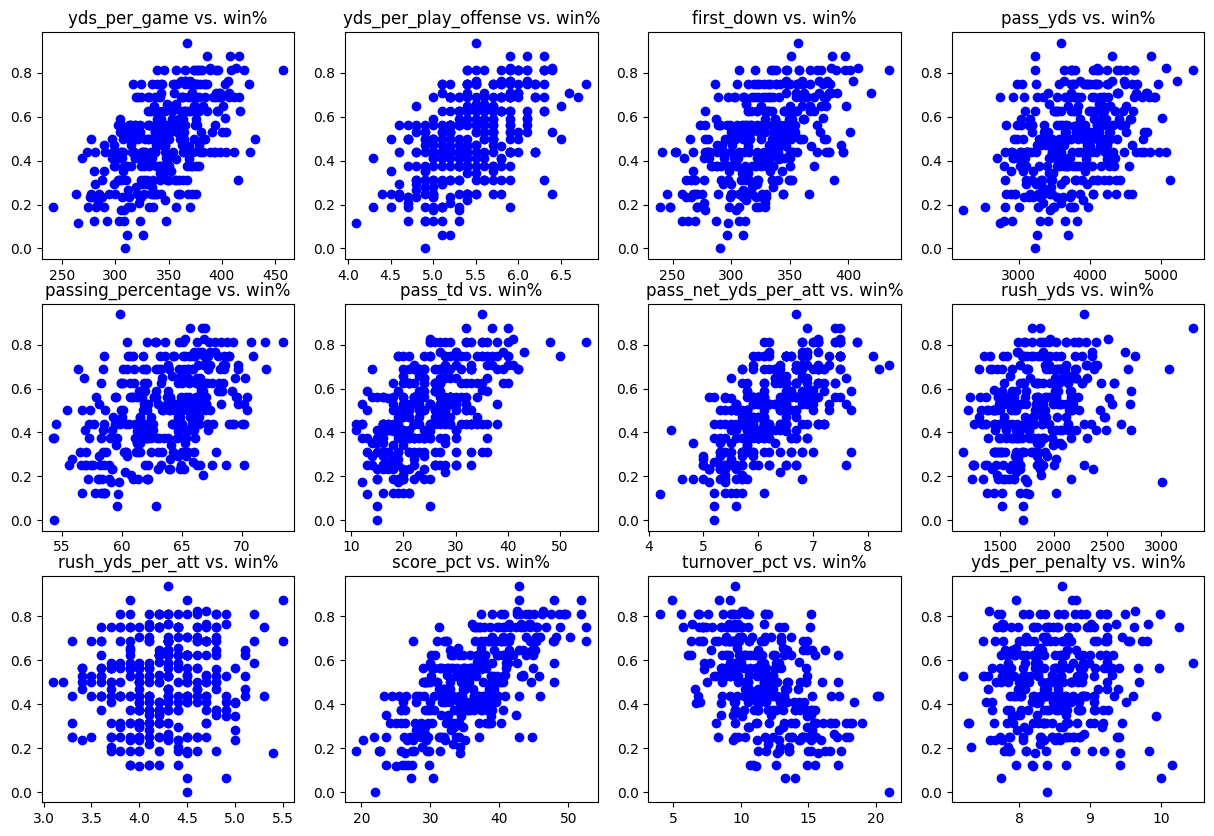

In [559]:
statistics = ['yds_per_game', 'yds_per_play_offense', 'first_down', 'pass_yds', 'passing_percentage', 'pass_td', 'pass_net_yds_per_att', 'rush_yds', 'rush_yds_per_att', 'score_pct', 'turnover_pct', 'yds_per_penalty']

fig, ax = plt.subplots(3, 4, figsize=(15, 10))
i = 1
for x in statistics:
    ax = plt.subplot(3, 4, i)
    plt.scatter(df_filtered[x], df_filtered['win_loss_perc'], color='blue')
    plt.title(f'{x} vs. win%')
    i = i+1


plt.show()

By looking at these statistics visually, we will be able to easily identify which have a correlation with win%. We can see that *rush_yds_per_att*, *rush_yds*, and *yds_per_penalty* are not good indicators of win% because the data seems to be spread out across the graph with no real correlation between the two variables. Meanwhile, *yds_per_game* and *score_pct* are good indicators of win% because we can see a general trend. Let's choose 6 statistics to use for training a model to determine win percentage - we can do this by fitting a linear regression to each of the statistics, and choosing the 4 highest r^2 values.

yds_per_game:		0.30497822589569035
yds_per_play_offense:	0.27828774669940975
first_down:		0.2818570250047301
pass_yds:		0.13835083585620273
passing_percentage:	0.1957454222040416
pass_td:		0.28738102380776837
pass_net_yds_per_att:	0.364314549748441
rush_yds:		0.10696901768980316
rush_yds_per_att:	0.015847145894714663
score_pct:		0.47615420862784635
turnover_pct:		0.2683715065784753
yds_per_penalty:	0.0065954981330202354


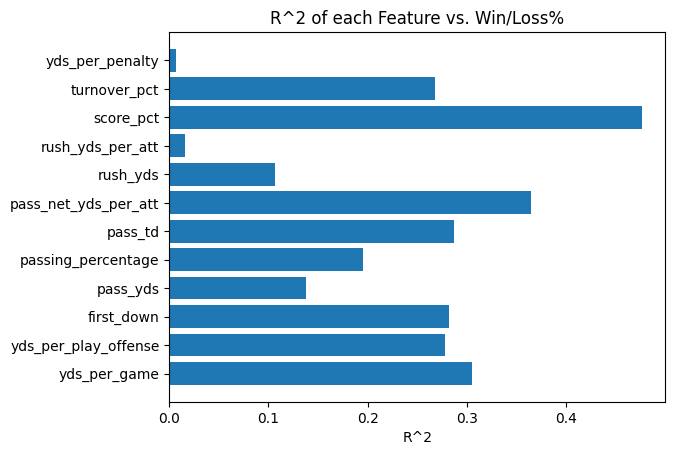

In [560]:
rs2 = []
for x in statistics:
    slope, intercept, r, p, err = linregress(df_filtered[x], df_filtered['win_loss_perc'])
    rs2.append(r**2)
    if len(x) <= 12:
        print(f"{x}:\t\t{r**2}")
    else:
        print(f"{x}:\t{r**2}")

# set plot size and labels
plt.title('R^2 of each Feature vs. Win/Loss%')
plt.xlabel('R^2')

# create horizontal bar graph with features on the y-axis and the coefficient of each feature as the width
plt.barh(y=statistics, width=rs2)
plt.show()

From this analysis, we can see that the top 4 statistics are:

  * yds_per_game: More yards per game lead to more scoring

  * first_down: More first downs gained lead to better offensive attempts

  * pass_net_yds_per_att: More yards per pass attempt lead to better offensive attempts 

  * score_pct: Higher score percentage leads to more points per offensive attempt

<h2>Linear Regression</h2>

Now, let's see if a multivariate linear regression model will do well to predict winning percentage. Let's seperate our data into a test and train dataframe, so that we have some data to check if our linear regression does well. This is done using <a href=https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.htmlLinearRegression()>SKLearn's LinearRegression()</a>.

Coefficients:
yds_per_game:		-0.0008585422494551992
first_down:		0.00010919459352396865
pass_net_yds_per_att:	0.07348906578807651
score_pct:		0.017125493212691956


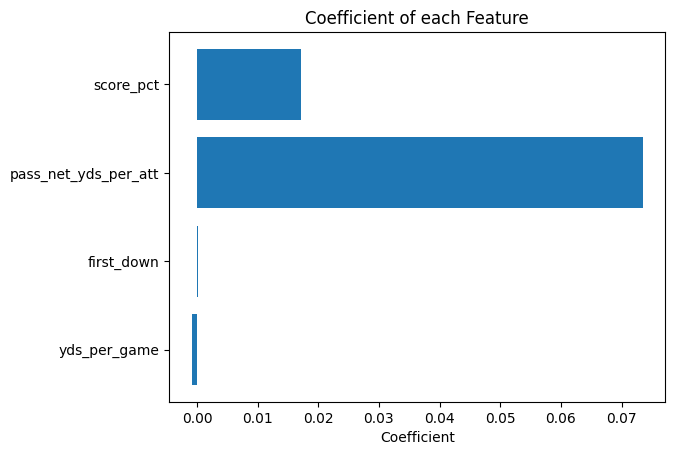

In [561]:
# Seperate test and train data
new_stats = ['yds_per_game', 'first_down', 'pass_net_yds_per_att', 'score_pct']
test = df_filtered.loc[df['year'] == 2023]
train = df_filtered.loc[df['year'] != 2023]

# Create LinearRegression from SKLearn
regr = linear_model.LinearRegression()
regr.fit(train[new_stats], train['win_loss_perc'])

print("Coefficients:")
for x in range(len(new_stats)):
    if len(new_stats[x]) <= 12:
        print(f'{new_stats[x]}:\t\t{regr.coef_[x]}')
    else:
        print(f'{new_stats[x]}:\t{regr.coef_[x]}')

# set plot size and labels
plt.title('Coefficient of each Feature')
plt.xlabel('Coefficient')

# create horizontal bar graph with features on the y-axis and the coefficient of each feature as the width
plt.barh(y=new_stats, width=regr.coef_)
plt.show()

Now that we've used SKLearn to perform our multivariate linear regression, let's test it out on our test dataframe, and see how well our linear regression does. We've saved all of the 2023 data to test on - we'll see why later. For now, let's check how far off the predictions are from the actual values, which should indicate how well the multivariate linear regression performs.

In [562]:
# Calculate predictions
predictions = regr.predict(test[new_stats])
actual = test['win_loss_perc']

# Find difference between predictions and actual data
difference = abs(predictions-actual)
print("Average difference in prediction vs. actual:",sum(difference)/len(difference))
print("Standard deviation of actual:", np.std(actual))
print("Accuracy score:", regr.score(test[new_stats], test['win_loss_perc']))

Average difference in prediction vs. actual: 0.07878449039317356
Standard deviation of actual: 0.15906051079306266
Accuracy score: 0.6116518352677056


Our linear regression model, on average, predicts 7.6% off from the actual win/loss percentage value. This may seem like a small amount, but when win loss percentages are centered around 50% and the standard deviation of win/loss percentage is 15%, 7% (half of one standard deviation) is a lot. The accuracy score of this linear regression is 64%, which leaves a lot of room for improvement. While this linear regression can help us predict, we can try to get better predictions. If we look at the previous graph that showed the coefficients, we can see that *yds_per_play_offense* has a much bigger impact on the predicted win/loss% than *yds_per_game*, even though *yds_per_game* had a higher R^2 value in the beginning. Perhaps the linear regression is not finding the best weights for this problem.

<h2>Gradient Descent</h2>

Let's use <a href=https://builtin.com/data-science/gradient-descent>gradient descent</a> to find the coefficients for our selected statistics. First, we need to standardize the data, as the scale and spread for the different statistics are very different. To make sure that each statistic is considered and one doesn't overpower the other just because of scale, we standardize the data. Then, we run our gradient descent algorithm.

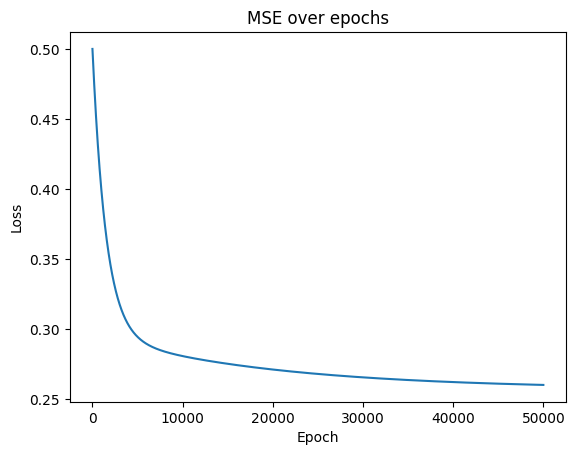

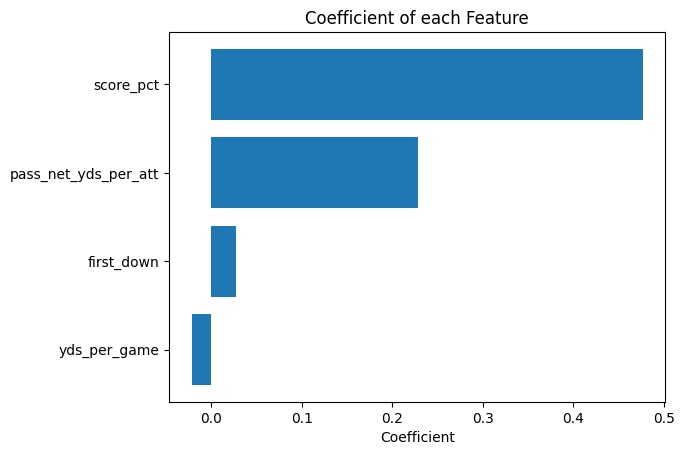

In [563]:
def grad_descent(X, y, T, alpha):
    m, n = X.shape # m = #examples, n = #features
    theta = np.zeros(n) # initialize parameters
    # print(theta)
    
    f = np.zeros(T) # track loss over time
    for i in range(T):
        # loss for current parameter vector theta
        errors = X.dot(theta) - y
        f[i] = 0.5*np.linalg.norm(errors)**2/m
        # compute steepest ascent at f(theta)
        g = np.transpose(X).dot(errors)/m
        # step down the gradient
        theta = theta - alpha*g
    return theta, f

ml_stats = ['yds_per_game', 'first_down', 'pass_net_yds_per_att', 'score_pct']

# Set up input and output data
X = train[ml_stats].values
y = train['win_loss_perc'].values

# Standardize our data
mean_X = np.mean(X, axis=0)
std_X = np.std(X, axis=0)
X_std = (X - mean_X) / std_X

mean_y = np.mean(y)
std_y = np.std(y)
y_std = (y - mean_y) / std_y

theta, f = grad_descent(X_std, y_std, 50000, 0.0001)

# Plot the loss function over epochs
plt.plot(f)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MSE over epochs')
plt.show()

# set plot size and labels
plt.title('Coefficient of each Feature')
plt.xlabel('Coefficient')

# create horizontal bar graph with features on the y-axis and the coefficient of each feature as the width
plt.barh(y=ml_stats, width=theta)
plt.show()


The first graph is a loss graph, which shows how well the model does over each training iteration. As the model goes through more epochs (iterations), the difference between the predicted values and the actual values in the training data goes down. The second graph shows the coefficient of each feature. Here, we can see that score_pct contributes the most to the win/loss percentage. However, the *yds_per_game* has a negative coefficient, which does not seem right. Let's retrain our model, but get rid of the yds_per_game input; this should be ok since *pass_net_yds_per_att* seems to be a big contributing factor to win/loss percentage already.

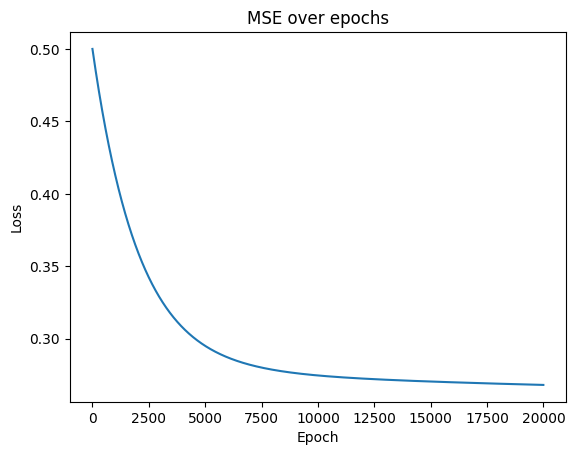

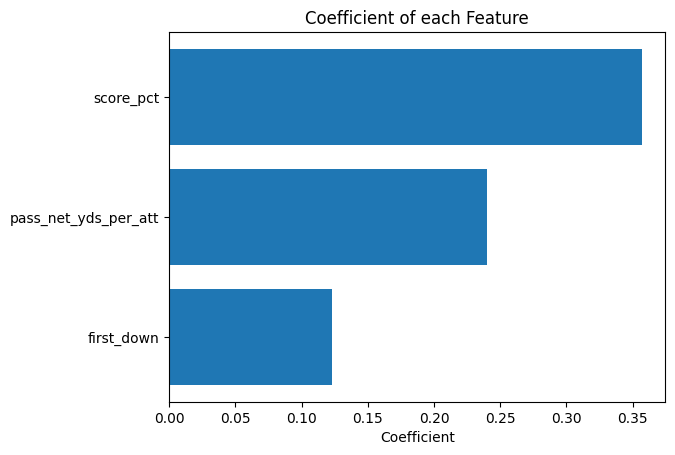

Average difference in prediction vs. actual: 0.0777494815465356


In [564]:
ml_stats = ['first_down', 'pass_net_yds_per_att', 'score_pct']

# Set up input and output data
X = train[ml_stats].values
y = train['win_loss_perc'].values

# Standardize our data
mean_X = np.mean(X, axis=0)
std_X = np.std(X, axis=0)
X_std = (X - mean_X) / std_X

mean_y = np.mean(y)
std_y = np.std(y)
y_std = (y - mean_y) / std_y

theta, f = grad_descent(X_std, y_std, 20000, 0.0001)

# Plot loss over Epochs
plt.plot(f)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MSE over epochs')
plt.show()

# set plot size and labels
plt.title('Coefficient of each Feature')
plt.xlabel('Coefficient')

# create horizontal bar graph with features on the y-axis and the coefficient of each feature as the width
plt.barh(y=ml_stats, width=theta)
plt.show()

# Calculate our predictions - standardize the inputs and calculate the actual outputs
predictions = []
i = 0
testX = test[ml_stats].values
testX_std = (testX - mean_X) / std_X

for row in testX_std:
    predictions.append(row.dot(theta)*std_y + mean_y)
    i = i+1

difference = abs(predictions-actual)
print("Average difference in prediction vs. actual:",sum(difference)/len(difference))

Now that our coefficients make sense, we can compare our average difference in prediction vs. actual to our linear regression model. We can see that our trained model performs better on 2023 data by 0.1%, which does not seem like much. However, these coefficients make much more sense than our linear regression coefficients. We can also attribute this to what we saw in the beginning: all of the statistics do not have a strong correlation to win/loss%, if at all! These predictions are still good for us to see how these statistics might influence a teams chance at winning.

To move forward, let's try something else. Let's look at the 2023 season and all of the matchups, and train a new model that tries to predict which team will win based on the existing 2023 statistics.

To do this, let's scrape data based on the 2023 season. We'll use <a href="https://www.selenium.dev/">Selenium</a> to grab the data from <a href="https://www.pro-football-reference.com/">ProFootballReference</a> for the 2023 season. While we're scraping the pages, let's create a new dataframe that will hold the data we need to train our new model. To do so, we need the point differential in the game, as well as the difference between the relevant statistics of the two teams. 

![alt text](score.png "Title")

To grab the data, we'll look at each individual game block shown on the website (and above). We'll use this and the XPath of the HTML code containing the text we need to get both of the teams and scores. Then, we'll look up the teams' statistics in our old dataframe, calculate the difference, and add it to a new one for later! By doing so, we will be able to try to predict point differential based on the statistics we've gathered so far.

In [565]:
# Create new dataframe
columns = ['yds_per_game', 'yds_per_play_offense', 'first_down', 'pass_yds', 'passing_percentage', 'pass_td', 'pass_net_yds_per_att', 'rush_yds', 'rush_yds_per_att', 'score_pct', 'turnover_pct', 'yds_per_penalty', 'point_diff']
df_matchup = pd.DataFrame(columns=columns)

# Iterate through all of the weeks
for x in range(1,19):
    # Initialize the Chrome driver
    driver = webdriver.Chrome()
    # Open the page
    driver.get(f"https://www.pro-football-reference.com/years/2023/week_{x}.htm#all_week_games")

    # Find each game table that shows the results of an individual game
    tables = driver.find_elements(By.XPATH, "//div[contains(@class, 'game_summary expanded nohover')]")

    # Loop through each table and extract the winner and loser
    for table in tables[1:]:
        try:
            winner = table.find_element(By.XPATH, ".//tr[contains(@class, 'winner')]").find_element(By.XPATH, ".//td").text
            loser = table.find_element(By.XPATH, ".//tr[contains(@class, 'loser')]").find_element(By.XPATH, ".//td").text
            winner_p = int(table.find_element(By.XPATH, ".//tr[contains(@class, 'winner')]").find_element(By.XPATH, ".//td[contains(@class,'right')]").text)
            loser_p = int(table.find_element(By.XPATH, ".//tr[contains(@class, 'loser')]").find_element(By.XPATH, ".//td[contains(@class,'right')]").text)
            
            diff = test.loc[test['team'] == winner][statistics].values - test.loc[test['team'] == loser][statistics].values


            # Append the new row to the DataFrame
            df_matchup.loc[len(df_matchup.index)] = np.append(diff[0], [(winner_p-loser_p)])

        except Exception as e:
            print(f"Error: {e}")

    # Close the browser
    driver.quit()


df_matchup.head(8)

,yds_per_game,yds_per_play_offense,first_down,pass_yds,passing_percentage,pass_td,pass_net_yds_per_att,rush_yds,rush_yds_per_att,score_pct,turnover_pct,yds_per_penalty,point_diff
0,43.529412,0.4,25.0,213.0,1.027520,2.0,0.6,527.0,0.3,1.3,-2.8,-0.111362,1.0
1,69.000000,1.1,29.0,783.0,1.971151,4.0,2.0,390.0,0.1,7.1,3.2,0.641355,14.0
2,16.941176,-0.4,-4.0,-202.0,-11.401657,-3.0,-0.4,490.0,-0.1,-1.7,7.7,-0.278947,21.0
3,2.764706,0.0,12.0,460.0,4.604923,4.0,0.2,-413.0,-0.7,-0.3,5.7,0.548510,10.0
4,-34.764706,-0.4,-40.0,-547.0,-3.110422,-2.0,-0.1,-44.0,-0.6,1.4,-8.6,-0.018090,3.0
5,48.176471,0.2,39.0,923.0,5.458238,14.0,0.7,-104.0,-0.6,4.0,-1.2,0.794318,1.0
6,94.117647,1.6,96.0,1221.0,4.597780,20.0,2.6,379.0,0.7,15.4,2.4,0.481810,23.0
7,28.000000,0.5,31.0,-538.0,3.558923,0.0,0.3,1014.0,1.2,5.9,2.3,1.143447,16.0


Now that we have out dataframe ready, let's run our gradient descent algorithm again. We'll save the last 5 games to test our model on, and train on the rest. Here, we're going to use all of the statistics that we have saved that might be relevant from our original dataframe. Then, we'll train it to try to predict the point differential we've scraped, tying everything together!

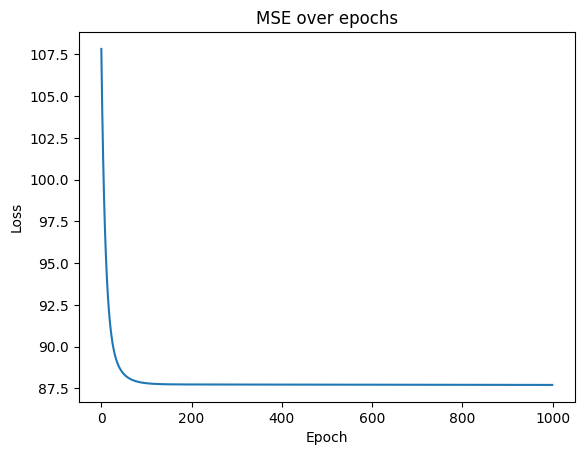

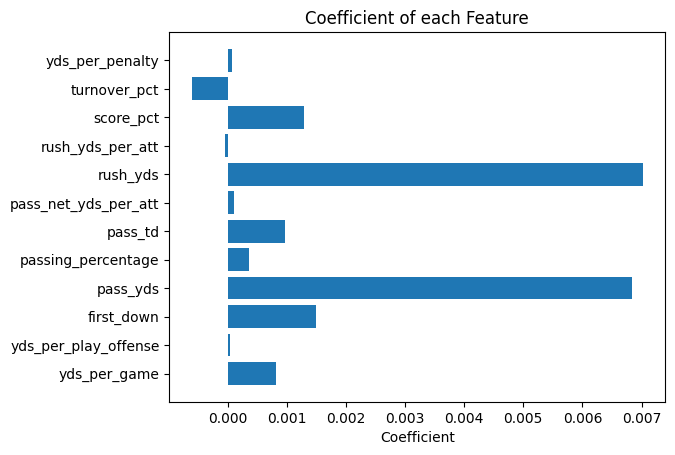

In [581]:
# Seperate test and train dataframes
test_df = df_matchup.head(5)
train_df = df_matchup.iloc[5:]

# Set up input and output for gradient descent
X = train_df[statistics].values
y = train_df['point_diff'].values

theta, f = grad_descent(X, y, 1000, 0.0000001)

plt.plot(f)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MSE over epochs')
plt.show()

# set plot size and labels
plt.title('Coefficient of each Feature')
plt.xlabel('Coefficient')

# create horizontal bar graph with features on the y-axis and the coefficient of each feature as the width
plt.barh(y=statistics, width=theta)
plt.show()

In [582]:
predictions = []
i = 0

# Calculate predictions for 5 test games
for index, row in test_df.iterrows():
    predictions.append(row[statistics].values.dot(theta))
    print('prediction: ', predictions[i], ' \tactual: ', row['point_diff'])
    i = i+1

difference = abs(predictions-test_df['point_diff'])
print("Average difference in prediction vs. actual:",sum(difference)/len(difference))

prediction:  5.234369621936899  	actual:  1.0
prediction:  8.204698524982627  	actual:  14.0
prediction:  2.0513116416876342  	actual:  21.0
prediction:  0.26968072060906406  	actual:  10.0
prediction:  -4.134532594133145  	actual:  3.0
Average difference in prediction vs. actual: 9.168642265758146


As we can see above, the prediction varies from the actual by an average of 9.1, which is a lot. It seems like our model does not work well in this case, and we would need to reconsider an approach to this. However, we can still look at the predictions to predict which team will win. In these test examples, the model correctly predicts a positive point differential 4 out of 5 times.

To improve, we might consider quadratic regression, or manipulating our inputs to try to obtain a more accurate prediction. 

<h2>Conclusion</h2>

To recap, we've parsed through NFL data and statistics to find what correlates with win/loss percentage the most. After analyzing graphs and looking at regression values, we performed Linear Regression to try to predict win/loss%. After analyzing our results, we performed gradient descent on the same data and compared the results after standardizing and removing some of the unnecessary inputs. Finally, we scraped data from <a href="https://www.pro-football-reference.com/">ProFootballReference</a> and combined it with our previous dataset to try to predict point differentials in individual games. Unfortunately, we did not find a good model, which does happen sometimes in data science projects.

Throughout this tutorial, we've shown how to:

  * Scrape data from a website
  * Parse through data using Pandas
  * Visualize data using Matplotlib
  * Perform Linear Regression using SKLearn
  * Use Gradient Descent to fit a model to data

More importantly, we've been able to try to predict the outcomes and win/loss percentages of NFL teams. While teams themselves definitely use this type of data analysis in their day to day lives - to predict what other teams might do or figure out what to focus on at practice, we can use this to help predict what outcomes might occur. If we find more data to use and fine tune our models, we could do statistical analysis on matchups and compare to how the betting sports books view each matchup; if we find that our odds are better than what Vegas thinks they are, we might just win big!